<a href="https://colab.research.google.com/github/abdulwasaeee/Pytorch-Bootcamp/blob/main/pytorch_CV_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm


In [29]:
torch.__version__

'2.8.0+cu126'

In [30]:
torchvision.__version__

'0.23.0+cu126'

In [31]:
traindata=datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [32]:
test=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [33]:
len(traindata), len(test)

(60000, 10000)

In [34]:
classnames=traindata.classes
classnames

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [35]:
classtoidx=traindata.class_to_idx
classtoidx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [36]:
image,label= traindata[0]
label

9

In [37]:
image.shape

torch.Size([1, 28, 28])

In [38]:
classnames[label]

'Ankle boot'

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

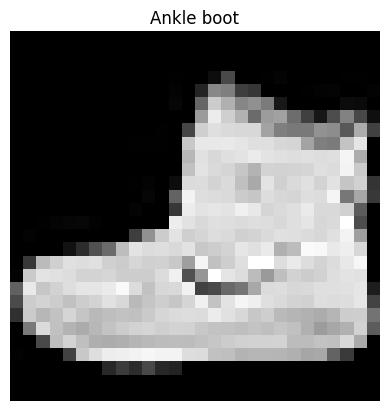

In [39]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(classnames[label])
plt.axis(False)

In [40]:
batchsize=32
dl=DataLoader(dataset=traindata, batch_size=batchsize, shuffle=False)
testdl=DataLoader(dataset=test, batch_size=batchsize, shuffle=False)

In [41]:
dl, testdl

(<torch.utils.data.dataloader.DataLoader at 0x7cfeb229d220>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfeb229d0d0>)

In [42]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnlayers=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )
    self.linearlayers=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64*7*7,out_features=128),
        nn.ReLU(),
        nn.Linear(128,10)
    )

  def forward(self,x):
    x=self.cnlayers(x)
    x=self.linearlayers(x)
    return x


In [43]:
model=CNN()

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CNN(
  (cnlayers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [45]:
opt= torch.optim.Adam(params=model.parameters(),lr=0.01)
lossfn=nn.CrossEntropyLoss()

In [46]:
dl.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [47]:
len(dl), len(dl.dataset)

(1875, 60000)

In [48]:
def training(model, dataloader, lossfn, optimizer, device="cpu"):
  model.train()
  totalloss=0
  for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        ypred = model(x)
        loss = lossfn(ypred, y)
        loss.backward()
        optimizer.step()
        totalloss += loss.item()
  return totalloss / len(dataloader)

In [49]:
def testing(model, dataloader, lossfn, device="cpu"):
  model.eval()
  totalloss=0
  correct=0

  with torch.inference_mode():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            loss = lossfn(ypred, y)
            totalloss += loss.item()
            preds = ypred.argmax(dim=1)
            correct += (preds == y).sum().item()
  return totalloss / len(dataloader), correct / len(testdl.dataset)

In [50]:
torch.manual_seed(42)
start = timer()

epochs = 5

for i in tqdm(range(epochs)):
    trainloss= training(model, dl, lossfn, opt, device=device)
    testloss, testacc= testing(model, testdl, lossfn, device=device)
end = timer()
totaltime = end - start
print(f"Total training time: {totaltime:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Total training time: 65.345 seconds


In [51]:
print(trainloss,testloss,testacc)

0.3224211713165045 0.4577971604495003 0.8542
